### Heston Model

The Heston model describes the evolution of a stock price $S_t$ whose variance $V_t$ is given by a mean reverting square root process:

\begin{eqnarray}
\frac{dS_t}{S_t} &=& \mu dt  + \sqrt{V_t}dW_t^{1},\\
dV_t &=& \kappa(\theta - V_t)dt  + \sigma \sqrt{V_t}dW_t^{2}.
\end{eqnarray}

A key characteristic of the model is that the Wiener processes are correlated $dW_t^{1}\cdot dW_t^{2}=\rho dt$. This feature enables the model to exhibit the 'leverage effect'. 

### Jump Diffusion Models: Bates Method

The Bates Jump-Diffusion model [BATES1993] is specified as the following set of coupled stochastic differential equations

\begin{equation}
\frac{dS_t}{S_t} = \mu dt  + \sqrt{V_t}dW_t^{1} + (Y-1)S_tdN_t,
\end{equation}
\begin{equation}
dV_t = \kappa(\theta - V_t)dt  + \sigma \sqrt{V_t}dW_t^{2},
\end{equation}

describing the evolution of a stock price $S_t$ whose variance $V_t$ is given by a mean reverting square root process which ensures that the variance is always positive provided that $2\kappa\theta - \sigma^2>0$. $N_t$ is a standard Poisson process with intensity $\lambda>0$ and $Y$ is the log-normal jump size distribution with mean $\mu_j=ln (1+a) - \frac{\sigma_j^2}{2},~a>-1$ and standard deviation $\sigma_j \geq 0$. 

Both $N(t)$ and $Y$ are independent of the Wiener processes $W_t^{1}$ and $W_t^{2}$.  A key characteristic of the model, which originates from the embedded Heston stochastic volatility diffusion model, is that the Wiener processes are correlated $dW_t^{1}\cdot dW_t^{2}=\rho dt$. This feature enables the model to exhibit the leverage effect. Note that simply excluding the compound Poisson term $(Y-1)S_tdN_t$ recovers the Heston model.

## Pricing
With marginal loss of generality, we will restrict the scope of this section to European equity options. Stochastic volatility models permit semi-analytical closed-form solutions for computing risk neutral European option prices. The price can be represented as a weighted sum of the delta of the European call option $P_1$ and $P_2$ - the probability that the asset price will
exceed the strike price at maturity. Adopting standard option pricing notation, the call price of a vanilla European option is

\begin{equation}
 C(S_0, K,\tau; \mathbf{z}_0) = S_0P_1 - K\exp\{-(r-q )\tau\}P_2,
\end{equation}

$P_1$ and $P_2$ can be expressed as:

\begin{equation}
P_j =\frac{1}{2} + \frac{1}{\pi} \int_{o}^{\infty} \text{Re}\left[\frac{\exp\{-iu ln K\}\phi_j (S_0,\tau,u; \mathbf{z}_0)}{iu}\right]du, j=1,2.
\end{equation}

where $\phi_j$ are Heston analytic characteristic functions and $\mathbf{z}_0$ is the vector of Heston model parameters.  

### Fourier-Cosine Method
An alternative approach to the Carr-Madan FFT approach is to use the Fourier-Cosine Method. Following Fang and Oosterlee [FANG2008], the entire inverse Fourier integral in the pricing equation is reconstructed from Fourier-cosine series expansion of the integrand to give the following approximation of the call price
\begin{equation}
C(S_0, K, \tau; \mathbf{z}_0) \approx Ke^{-r\tau} \cdot \text{Re}\{\sum_{k=0}^{N-1}'\phi\left(\frac{k\pi}{b-a};\mathbf{z}_0\right)e^{ik\pi\frac{x - a}{b-a}}U_k\},
\end{equation}
where $x:= ln(S_0/K)$ and $\phi(w;\mathbf{z}_0)$ denotes the characteristic function of the log-asset price, $U_k$ the payoff series coefficients and $N$ denotes the number of terms in the cosine series expansion (typically 128 will suffice). 

For the approximation of the Heston model call price, the Fourier-Cosine approach is shown to be superior in convergence properties to other FFT and quadrature based methods in [DIXON2013].


<img src="error_convergence.png">

In [1]:
from random import Random
from numpy import *
from scipy import *
from time import *
from datetime import *
import numpy as np
import sys
import csv

%matplotlib inline

In [2]:
### Implement the Fourier-Cosine Method
def HestonCOS(S,K,T,r,sigma,lmbda,meanV,v0,rho, otype, N=256):
    c1 = r*T+(1-exp(-lmbda*T))*(meanV-v0)/(2.0*lmbda)-0.5*meanV*T
    c2 = 1.0/(8.0*lmbda**3)*(sigma*T*lmbda*exp(-lmbda*T)*(v0-meanV)*(8.0*lmbda*rho-4.0*sigma)+lmbda*rho*sigma*(1-exp(-lmbda*T))*(16.0*meanV-8.0*v0)+2.0*meanV*lmbda*T*(-4.0*lmbda*rho*sigma+sigma**2+4.0*lmbda**2)+sigma**2*((meanV-2.0*v0)*exp(-2.0*lmbda*T)+meanV*(6.0*exp(-lmbda*T)-7.0)+2.0*v0)+8.0*lmbda**2*(v0-meanV)*(1-exp(-lmbda*T)))
    a = c1-12.0*sqrt(abs(c2))
    b = c1+12.0*sqrt(abs(c2))
    x = log(float(S)/K)
    k = arange(0,N)
    if (otype == 'C'):
       U = 2.0/(b-a)*(xi(k,a,b,0,b) - psi(k,a,b,0,b))
    else:
       U = 2.0/(b-a)*(-xi(k,a,b,a,0) + psi(k,a,b,a,0))   
    unit = [1.0] * N
    unit[0] = 0.5
    ret = 0
# Note that HestonCF is independent of the strike
    HCF = HestonCF(k*pi/(b-a),T,r,sigma,lmbda,meanV,v0,rho)
    for i in range(N):
      ret += unit[i]*HCF[i]*exp(1j*float(k[i])*pi*(x-a)/(b-a))*U[i]
    return K*exp(-r*T)*ret.real

def HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, otype, N=256):
    c1 = r*T+(1-exp(-lmbda*T))*(meanV-v0)/(2.0*lmbda)-0.5*meanV*T
    c2 = 1.0/(8.0*lmbda**3)*(sigma*T*lmbda*exp(-lmbda*T)*(v0-meanV)*(8.0*lmbda*rho-4.0*sigma)+lmbda*rho*sigma*(1-exp(-lmbda*T))*(16.0*meanV-8.0*v0)+2.0*meanV*lmbda*T*(-4.0*lmbda*rho*sigma+sigma**2+4.0*lmbda**2)+sigma**2*((meanV-2.0*v0)*exp(-2.0*lmbda*T)+meanV*(6.0*exp(-lmbda*T)-7.0)+2.0*v0)+8.0*lmbda**2*(v0-meanV)*(1-exp(-lmbda*T)))
    a = c1-12.0*sqrt(abs(c2))
    b = c1+12.0*sqrt(abs(c2))
    x = log(float(S)/K)
    k = arange(0,N)
    if (otype == 'C'):
       U = 2.0/(b-a)*(xi(k,a,b,0,b) - psi(k,a,b,0,b))
    else:
       U = 2.0/(b-a)*(-xi(k,a,b,a,0) + psi(k,a,b,a,0))   
    unit = [1.0] * N
    unit[0] = 0.5
    ret = 0
# Note that HestonCF is independent of the strike
    HCF = HestonCFdu0(k*pi/(b-a),T,r,sigma,lmbda,meanV,v0,rho)
    for i in range(N):
      ret += unit[i]*HCF[i]*exp(1j*float(k[i])*pi*(x-a)/(b-a))*U[i]
    return K*exp(-r*T)*ret.real


def HestonCF(u,T,r,sigma,lmbda,meanV,v0,rho):
    a = lmbda*meanV
    b = lmbda
    d = sqrt((1j*rho*sigma*u-b)**2+(u**2+1j*u)*sigma**2)
    g = (b-1j*rho*sigma*u-d)/(b-1j*rho*sigma*u+d)
    ret = exp(1j*u*r*T)
    ret = ret*exp((a/sigma**2)*((b - rho*1j*sigma*u - d)*T - 2.0*log((1-g*exp(-d*T))/(1-g))))
    return ret*exp((v0/sigma**2)*(b - rho*1j*sigma*u - d)*(1-exp(-d*T))/(1-g*exp(-d*T)))


# The Derivative of the Heston Characteristic Function w.r.t. to the v0 
def HestonCFdu0(u,T,r,sigma,lmbda,meanV,v0,rho):

    a = lmbda*meanV
    b = lmbda
    d = sqrt((1j*rho*sigma*u-b)**2+(u**2+1j*u)*sigma**2)
    g = (b-1j*rho*sigma*u-d)/(b-1j*rho*sigma*u+d)
    ret = exp(1j*u*r*T)
    
    ret = ret*exp((a/sigma**2)*((b - rho*1j*sigma*u - d)*T - 2.0*log((1.0-g*exp(-d*T))/(1.0-g))))
    ret = ret*exp((v0/sigma**2)*(b - rho*1j*sigma*u - d)*(1.0-exp(-d*T))/(1.0-g*exp(-d*T)))
    ret = ret *((1.0-exp(-d*T))/(1.0-g*exp(-d*T)))*(b-1j*rho*sigma*u-d)/(sigma**2)
    return(ret)



def xi(k,a,b,c,d):
    ret = 1.0/(1+(k*pi/(b-a))**2)*(cos(k*pi*(d-a)/(b-a))*exp(d)-cos(k*pi*(c-a)/(b-a))*exp(c)+k*pi/(b-a)*sin(k*pi*(d-a)/(b-a))*exp(d)-k*pi/(b-a)*sin(k*pi*(c-a)/(b-a))*exp(c))
    return ret

def psi(k,a,b,c,d):
    N = len(k)
    idx = arange(1, N)
    ret = array([0.0]*N)
    ret[0] = d-c
    ret[idx] =(sin(k[idx]*pi*(d-a)/(b-a))-sin(k[idx]*pi*(c-a)/(b-a)))*(b-a)/(k[idx]*pi)
    return ret



In [3]:
import matplotlib.pyplot as plt

In [4]:
nInt = 256
r0 = 0.0002

#p0 = [5.76145232379, 0.393696857573, 0.99999999,-0.686387364593,0.685888435264]
#print Error_Function(p0)

S= 100
K = 100
T = 0.01
r = r0
sigma = 0.6
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho =-0.9
V= HestonCOS(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt)

vegas = []
S_arr = np.arange(90,110,0.1)
for S in S_arr:
  vegas.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt));


Text(0,0.5,'vegas')

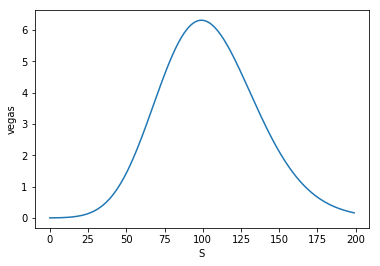

In [5]:
plt.plot(vegas)
plt.xlabel('S')
plt.ylabel('vegas')

What if we just fit the regression to a smaller number of points

In [6]:
idx = np.arange(1,len(S_arr),40)

In [7]:
rg = np.polyfit(S_arr[idx], np.array(vegas)[idx], 4)
vegas_reg = np.polyval(rg, S_arr[idx])  # continuation values

S_arr[idx], np.array(vegas)[idx], vegas_reg

(array([  90.1,   94.1,   98.1,  102.1,  106.1]),
 array([  3.06921759e-03,   7.22017269e-01,   5.28408471e+00,
          5.05346261e+00,   1.32383761e+00]),
 array([  3.06921770e-03,   7.22017269e-01,   5.28408471e+00,
          5.05346261e+00,   1.32383761e+00]))

Text(0,0.5,'vegas')

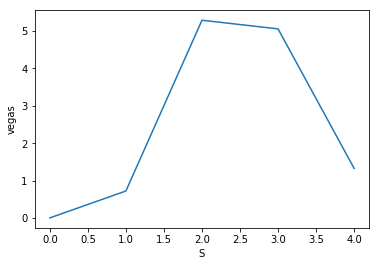

In [8]:
plt.plot(vegas_reg)
plt.xlabel('S')
plt.ylabel('vegas')

What if I fit polynomial regression

In [9]:
x = S_arr[idx]
y = np.array(vegas)[idx]
p3=np.polyfit(x, y, 3)
p3_test = np.polyval(np.polyfit(S_arr, np.array(vegas), 3), S_arr)
x,y

(array([  90.1,   94.1,   98.1,  102.1,  106.1]),
 array([  3.06921759e-03,   7.22017269e-01,   5.28408471e+00,
          5.05346261e+00,   1.32383761e+00]))

In [10]:
def p3_func(x):
    ret = p3[0] * (x**3) + p3[1] * (x**2) + p3[2] * x + p3[3]
    return ret

In [11]:
poly_reg = []
for S in S_arr:
    poly_reg.append(p3_func(S))

(-3, 9)

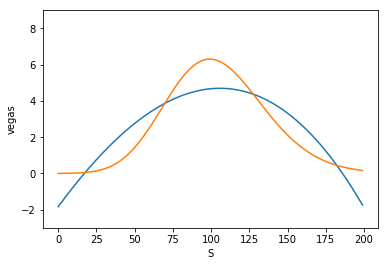

In [60]:
plt.plot(p3_test)
plt.plot(vegas)
plt.xlabel('S')
plt.ylabel('vegas')
plt.ylim(-3,9)


Apply GPR with training point sets

In [41]:
# Initiate dataset
i = np.arange(200)[0:200:2]
j = np.arange(200)[1:200:2]
x_train = S_arr[i].reshape(100,1)
y_train = np.array(vegas)[i]
x_test = S_arr[j].reshape(100,1)
y_test = np.array(vegas)[j]



In [16]:
#GPR WITH EDWARD
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import tensorflow as tf
import edward as ed
from edward.models import Normal

In [17]:
n = 100
d = 1
qw = Normal(loc=tf.get_variable("qw/loc", [d]),
            scale=tf.nn.softplus(tf.get_variable("qw/scale", [d])))
qb = Normal(loc=tf.get_variable("qb/loc", [1]),
            scale=tf.nn.softplus(tf.get_variable("qb/scale", [1])))

In [32]:
X = tf.placeholder(tf.float32, [n, d])
w = Normal(loc=tf.zeros(d), scale=tf.ones(d))
b = Normal(loc=tf.zeros(1.), scale=tf.ones(1.))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(n))

In [33]:
inference = ed.KLqp({w : qw, b: qb}, data={X: x_train, y: y_train})
inference.run(n_samples=10, n_iter=4000)

4000/4000 [100%] ██████████████████████████████ Elapsed: 11s | Loss: 349.589


In [57]:
post_q = qw.mean().eval() # if this is the right way of finding w, then which is which? 
post_b = qb.mean().eval() 

In [42]:
#criticism
y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(n))

print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: x_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: x_test, y_post: y_test}))

Mean squared error on test data:
4.88991
Mean absolute error on test data:
1.97157


In [51]:
def visualise(x_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[:, 0].eval()
  b_samples = b.sample(n_samples).eval()
  #plt.scatter(x_data, y_data)
  inputs = np.linspace(-10,10, num=400)
  for ns in range(n_samples):
    output = inputs * w_samples[ns] + b_samples[ns]
    plt.plot(inputs, output)

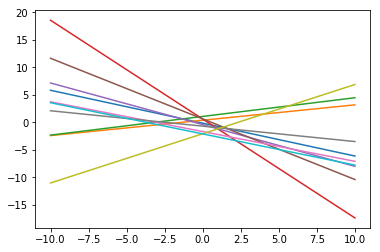

In [52]:
visualise(x_train, y_train, w, b)

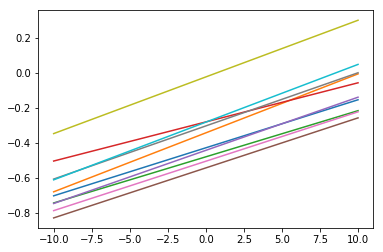

In [53]:
visualise(x_test, y_test, qw, qb)